# PHYSICS 111A Final Project

### Name: Jake Lansberg and Paul Roberts

## Initial setup

In [1]:

import sys
sys.path.append('..')

This allows us to import pydwf from the top-level directory:

Re-import whenever we change the code in our script:

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#%matplotlib qt
#%matplotlib widget
%matplotlib inline

Import objects:

In [4]:
from typing import TypeAlias, Any, Optional
from enum import IntEnum, StrEnum, unique
from functools import partial
import time
import pydwf

from dwf_funcs import scan_heartbeat, ScanType, _configure_analog_out, _acquire_single, _calc_demod, create_figure, _check_axs, _calc_scope_params, _set_color_cycles, _acquire_record, _demod, _configure_analog_in, _run_acquistion

import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

from cycler import cycler, Cycler

import scipy.fftpack


from pydwf import (
    DwfLibrary,
    DwfEnumConfigInfo,
    DwfAnalogOutNode,
    DwfAnalogOutFunction,
    DwfAcquisitionMode,
    DwfTriggerSource,
    DwfAnalogInTriggerType,
    DwfTriggerSlope,
    DwfState,
    DwfAnalogInFilter,
    AnalogIn,
    AnalogOut
)
from pydwf.utilities import openDwfDevice

RangeLimits: TypeAlias = Optional[tuple[float, float]]



@unique
class ChannelIndex(IntEnum):
    '''Enum for the two scope channel indices.'''
    CH1 = 0
    CH2 = 1

import numpy.random


In [6]:
# Frequencies of Notes in the 0th octave of human hearing, in hz
dict = {"c0": 16.35, "Db0": 17.32, "D0": 18.35, "Eb0": 19.45,
"E0": 20.60, "F0": 21.83, "Gb0": 23.12, "G0": 24.50,
"Ab0": 25.96, "A0": 27.50, "Bb0": 29.14, "B0": 30.87}

for i in dict:

    print(i)

c0
Db0
D0
Eb0
E0
F0
Gb0
G0
Ab0
A0
Bb0
B0


In [7]:
def tuner(freq, low_E_string = 82.41, A_string = 110, D_string = 146.83, G_string = 196, B_string = 246.94, high_E_string = 329.63):

    tuning = {"low_E_string": low_E_string, "A_string": A_string,
              "D_string": D_string, "G_string": G_string, "B_string": B_string, 
              "high_E_string": high_E_string}
        
    # for freq in freqs:

    result = False

    for string in tuning:

        if freq >= (tuning[string] - 10) and freq <= (tuning[string] + 10):

            differecne = freq - tuning[string]

            if freq >= (tuning[string] - 3) and freq <= (tuning[string] + 3):

                result = True
                return result

            elif differecne > 0:

                print("Note is " f"{differecne}" + "hz sharp of the" + string)
                result = False

            elif differecne < 0:

                print("Note is " f"{np.abs(differecne)}" + "hz flat of the" + string)
                result = False

    return result

In [8]:
scan_heartbeat(
    ScanType.TEST,
    fig=None,
    axs=None,
    test_output=True,
    analog_out_frequency = 10.0,
    analog_out_amplitude = 2.0,
    analog_out_offset = 0.5,
)

test_output=True,
analog_out_frequency = 10.0,
analog_out_amplitude = 2.0,
analog_out_offset = 0.5,

Configuring analog output signal (10.0 Hz)...
Started analog output.
Output running continuously. Interrupt program to quit.
Program quit successfully.


In [132]:
def extract_frequency(record, sampling_rate, analog_out_frequency):
    """
    Extract the fundamental frequency from a voltage record.

    Parameters
    ----------
    record : np.ndarray
        Array of voltage measurements from the microphone.
    sampling_rate : float
        Sampling rate of the data acquisition (in Hz).

    Returns
    -------
    fundamental_freq : float
        Detected fundamental frequency (in Hz).
    """

    # Assuming analog_out_frequency is a known carrier/modulation frequency
    time_sample = np.linspace(0, len(record) / sampling_rate, len(record))

    # Use `_demod` to preprocess the signal
    _, record_demod = _demod(
        analog_out_frequency=analog_out_frequency,
        time_sample=time_sample,
        record=np.column_stack((record, np.sin(2 * np.pi * analog_out_frequency * time_sample)))
    )

    # Perform FFT on demodulated signal
    fft_result = np.fft.fft(record_demod)
    fft_freqs = np.fft.fftfreq(len(fft_result), d=1/sampling_rate)
    magnitude = np.abs(fft_result)

    print(magnitude)

    fundamental_freq = fft_freqs[np.argmax(magnitude)]
    print(f"Fundamental frequency after demodulation: {fundamental_freq:.2f} Hz")


    # Ignore negative frequencies
    positive_freqs = fft_freqs[fft_freqs >= 0]
    positive_magnitude = magnitude[fft_freqs >= 0]

    # Find the average
    peak_index = np.argmax(positive_magnitude)
    fundamental_freq = positive_freqs[peak_index]



    return fundamental_freq


In [39]:
# Initialize library and open device
# dwf = pydwf.DwfLibrary()

# Attempt to open the device
with openDwfDevice(dwf) as device:
    if not device:
        raise RuntimeError("Failed to open device. Check the connection.")
    print("Device successfully opened!")
    # Your code here

Device successfully opened!


<class 'float'> 1000000.0

scan_type: DEMOD
num_records: 10 records
analog_out_frequency: 10.0 Hz
analog_in_frequency: 1000000.0 Hz
record_length_time: 10 seconds
record_length_samples: 16384 samples per record

Acquiring record 1...
Estimated demodulation angle: 179.9981999999997 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Acquiring record 2...
Estimated demodulation angle: 179.9981999999997 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Acquiring record 3...
Estimated demodulation angle: -179.99778455520394 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Acquiring record 4...
Estimated demodulation angle: 179.99746478671406 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Acquiring record 5...
Estimated demodulation angle: -0.008324920514371632 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Acquiring record 6...
Estimated demodulation angle: -0.001250526879289999 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Acquiring record 7...
Estimated demodulation angle: -0.00147577679001829 deg
n_filt 100

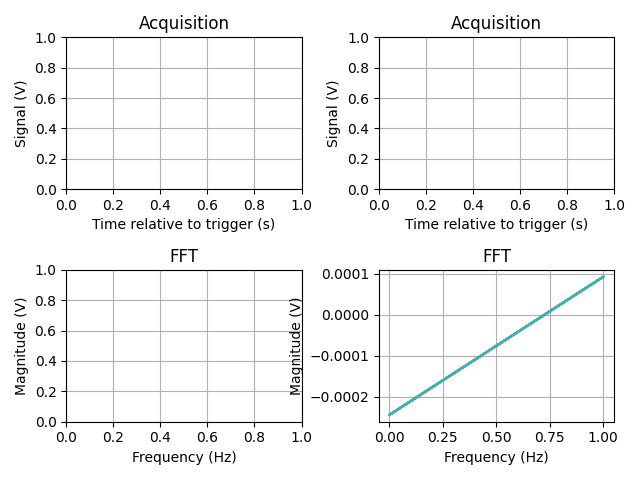

In [148]:
def run_function(
    scan_type: ScanType,
    fig: Optional[Figure],
    axs: Optional[NDArray],
    test_output: bool = False,
    num_records: int = 1,
    analog_out_frequency: float = 10.0,
    analog_out_amplitude: float = 1.0,
    analog_out_offset: float = 0.0,
    analog_out_shape: pydwf.DwfAnalogOutFunction = pydwf.DwfAnalogOutFunction.Sine,
    analog_in_channel_indices: tuple[ChannelIndex, ...] = (ChannelIndex.CH1, ChannelIndex.CH2),
    analog_in_channel_ranges: tuple[float, ...] = (5.0, 5.0),
    analog_in_frequency: Optional[float] = None,
    record_length_time: Optional[float] = 10.0,
    record_length_samples: Optional[int] = 16384,
    analog_out_channel_index: ChannelIndex = ChannelIndex.CH1,
    analog_out_symmetry: float = 50.0,
    analog_out_node: pydwf.DwfAnalogOutNode = pydwf.DwfAnalogOutNode.Carrier,
    analog_in_trigger_flag: bool = True,
    analog_in_trigger_source: pydwf.DwfTriggerSource = pydwf.DwfTriggerSource.AnalogOut1,
    analog_in_trigger_level: float = 0.0,
    analog_in_trigger_channel: ChannelIndex = ChannelIndex.CH1,
    xlim_time_raw: RangeLimits = None,
    xlim_freq_raw: RangeLimits = None,
    xlim_time_result: RangeLimits = None,
    xlim_freq_result: RangeLimits = None,
    overplot_fft: bool = True,
    cycler_time_raw: Optional[Cycler] = None,
    cycler_freq_raw: Optional[Cycler] = None,
    cycler_time_result: Optional[Cycler] = None,
    cycler_freq_result: Optional[Cycler] = None):


    if not test_output:

        if fig is None or axs is None:
            fig, axs = create_figure(scan_type=scan_type)
        else:
            _check_axs(scan_type, axs)

        # analog_in_frequency, record_length_time, record_length_samples = _calc_scope_params(
        #     analog_in_frequency, record_length_time, record_length_samples
        # )

        # if scan_type in (ScanType.DEMOD, ScanType.LOCKIN) and len(analog_in_channel_indices) != 2:
        #     raise ValueError(f'scan_type {scan_type} expects analog_in_channel_indices of length 2')

        # cycler_time_raw, cycler_time_result, cycler_freq_raw, cycler_freq_result = _set_color_cycles(
        #     analog_in_channel_indices,
        #     cycler_time_raw,
        #     cycler_time_result,
        #     cycler_freq_raw,
        #     cycler_freq_result
        # )


    with openDwfDevice(
        pydwf.DwfLibrary(),
        score_func=lambda conf_params: conf_params[pydwf.DwfEnumConfigInfo.AnalogInBufferSize]
    ) as device:
        
        # Initialize analog input
        analog_in = device.analogIn

        # Configure the analog input
        analog_in.frequencySet(1e6)  # Sampling rate: 1 MHz
        analog_in.channelEnableSet(0, True)  # Enable CH1 (index 0)
        analog_in.channelRangeSet(0, 5.0)  # Set range to ±5V
        
        # analog_in = device.analogIn

        print(type(analog_in_frequency), analog_in_frequency)


        # Configure analog input
        analog_in.frequencySet(analog_in_frequency)
        analog_in.channelEnableSet(ChannelIndex.CH1, True)
        analog_in.channelRangeSet(ChannelIndex.CH1, analog_in_channel_ranges[0])

        # Start analog input
        analog_in.configure(False, True)
        # time.sleep(0.1)  # Allow some time for data to stabilize

        # Configuration Parameters
        record_length_samples = 16384  # Number of samples to acquire
        sampling_frequency = 1e6  # Sampling rate: 1 MHz
        channel_indices = (0,)  # Use CH1 (index 0)
        trigger_flag = False  # No trigger for simplicity


        # THIS SHOULD BE THE RAW DATA

        recording = _run_acquistion(analog_in,
                                    scan_type,
                                    fig,
                                    axs,
                                    num_records,
                                    analog_out_frequency,
                                    analog_in_frequency,
                                    record_length_time,
                                    record_length_samples,
                                    channel_indices,
                                    analog_in_trigger_flag,
                                    overplot_fft,
                                    xlim_time_raw,
                                    xlim_freq_raw,
                                    xlim_time_result,
                                    xlim_freq_result,
                                    cycler_time_raw,
                                    cycler_freq_raw,
                                    cycler_time_result,
                                    cycler_freq_result)
        
        print(f"{recording = }")
        

        # NOW WE NEED TO MANIPULATE IT

        FFT_data = extract_frequency(recording, sampling_frequency, analog_out_frequency)

        # NOW WE SEND THE SIGNAL OUT

        print(f"{FFT_data =}")
        print("HELO LOOK AT ME")

        try:
            num_records_taken=0
            while num_records_taken<num_records:

                print(f"{recording = }")

                plt.plot(recording)

                

                print(f"{FFT_data =}")


                # Initialize AnalogIn
                analog_in = device.analogIn
                analog_in.frequencySet(sampling_frequency)
                analog_in.channelEnableSet(0, True)  # Enable CH1
                analog_in.channelRangeSet(0, 5.0)  # ±5V range
                analog_in.configure(False, True)  # Start acquisition


                result = tuner(FFT_data)

                if result:
                    print("In tune!")
                    # Turn on green LED
                    _configure_analog_out(
                        analog_out=device.analogOut,
                        channel_index=ChannelIndex.CH1,
                        frequency=analog_out_frequency,
                        amplitude=analog_out_amplitude,
                        offset=analog_out_offset,
                        shape=analog_out_shape,
                        symmetry=analog_out_symmetry,
                        node=analog_out_node
                    )

                    print("hello!")

                elif not result:
                    print("Out of tune!")
                    # Turn on blue LED
                    _configure_analog_out(
                        analog_out=device.analogOut,
                        channel_index=ChannelIndex.CH2,
                        frequency=analog_out_frequency,
                        amplitude=analog_out_amplitude,
                        offset=analog_out_offset,
                        shape=analog_out_shape,
                        symmetry=analog_out_symmetry,
                        node=analog_out_node
                    )
                time.sleep(0.1)
                num_records_taken += 1
        except KeyboardInterrupt:
            print("Program quit successfully.")

        # confihyuring analogi in

        _configure_analog_in(
            analog_in=device.analogIn,
            frequency=analog_in_frequency,
            record_length_time=record_length_time,
            channel_indices=analog_in_channel_indices,
            channel_ranges=analog_in_channel_ranges,
            trigger_flag=analog_in_trigger_flag,
            trigger_source=analog_in_trigger_source,
            trigger_level=analog_in_trigger_level,
            trigger_channel=analog_in_trigger_channel
        )
    return recording
    


recording = run_function(
    ScanType.DEMOD,
    fig=None,
    axs=None,
    test_output=False,
    analog_out_frequency = 10.0,
    analog_out_amplitude = 2.0,
    analog_out_offset = 0.5,
    num_records= 10,
    analog_in_frequency = 1e6,  # Example: 1 MHz sampling rate
    record_length_time = 10,
    record_length_samples=None
)


Configuring analog output signal (1000 Hz)...
Started analog output.
Acquistion Mode: DwfAcquisitionMode.Record

scan_type: LOCKIN
num_records: 500 records
analog_out_frequency: 1000 Hz
analog_in_frequency: 327680.0 Hz
record_length_time: 0.05 seconds
record_length_samples: 16384 samples per record

Acquiring record 1...
Total number of ADC queries for this event: 103
Estimated demodulation angle: -47.16588789907253 deg
Acquiring record 2...
Total number of ADC queries for this event: 174
Estimated demodulation angle: -78.51402083911944 deg
Acquiring record 3...
Total number of ADC queries for this event: 147
Estimated demodulation angle: -53.12607027359549 deg
Acquiring record 4...


/Users/jakelansberg/Desktop/111a/111a_FP/physics-111a-student/Final Project/dwf_funcs.py:700: RuntimeWarning: invalid value encountered in divide
  lockin_frequency = num_records_taken / (time_lockin[num_records_taken] - time_lockin[0])


Total number of ADC queries for this event: 135
Estimated demodulation angle: -21.590714545874015 deg
Acquiring record 5...
Total number of ADC queries for this event: 137
Estimated demodulation angle: -16.69128762261359 deg
Acquiring record 6...
Total number of ADC queries for this event: 149
Estimated demodulation angle: -16.649011225336256 deg
Acquiring record 7...
Total number of ADC queries for this event: 158
Estimated demodulation angle: -58.79917269407155 deg
Acquiring record 8...
Total number of ADC queries for this event: 143
Estimated demodulation angle: -71.5030618926382 deg
Acquiring record 9...
Total number of ADC queries for this event: 137
Estimated demodulation angle: -65.5380471281678 deg
Acquiring record 10...
Total number of ADC queries for this event: 144
Estimated demodulation angle: -43.602158853626456 deg
Acquiring record 11...
Total number of ADC queries for this event: 148
Estimated demodulation angle: -47.69700877401108 deg
Acquiring record 12...
Total number

KeyboardInterrupt: 

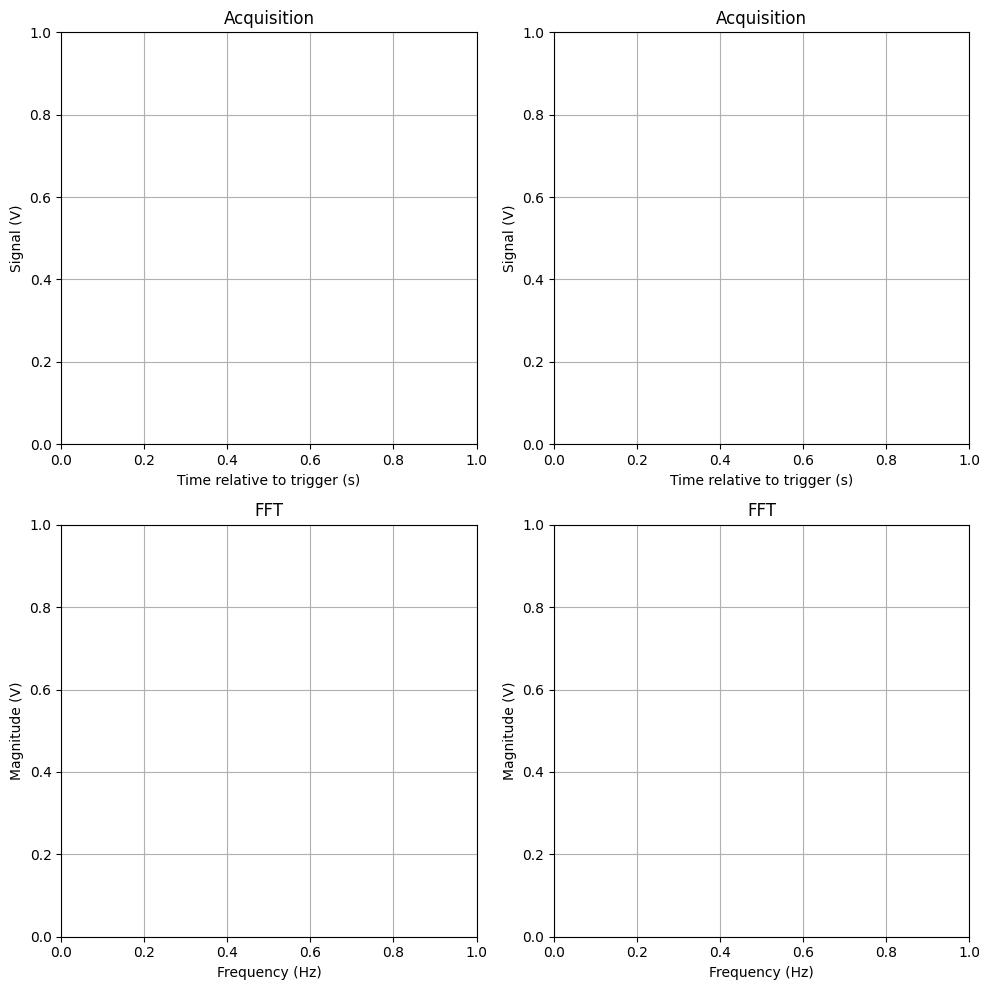

In [16]:
# Run this AFTER making changes to the script
from dwf_funcs import scan_heartbeat, DwfAnalogOutFunction

# Change `None` to the appropriate scan type and `(1, 1)` to your desired figure size
fig6, axs6 = create_figure(ScanType.LOCKIN, figsize=(10, 10));

scan_heartbeat(
        ScanType.LOCKIN,
        fig=fig6,
        axs=axs6,
        test_output= False,
        num_records=500,
        analog_out_shape = DwfAnalogOutFunction.Sine,
        analog_out_frequency = 1000,
        analog_out_amplitude = 0.25,
        analog_out_offset = 1.9,
        #analog_in_frequency = 40000,
        record_length_time = 0.05, # might be 10?
        record_length_samples = 16384, #could be 16384
        xlim_freq_raw=[0,2000],
        xlim_time_raw= [0, 0.002],
        xlim_time_result= [0,10],
        xlim_freq_result= [0,5],
        #analog_in_channel_ranges= (24.0, 24.0)

)

In [149]:
recording

array([[-2.44482160e-04],
       [ 9.31376273e-05]])

Configuring analog output signal (10.0 Hz)...
Started analog output.
Acquistion Mode: DwfAcquisitionMode.Record

scan_type: DEMOD
num_records: 1 record
analog_out_frequency: 10.0 Hz
analog_in_frequency: 40000 Hz
record_length_time: 10.0 seconds
record_length_samples: 400000 samples per record

Acquiring record 1...
Total number of ADC queries for this event: 36978
- NOTE - discarding newest 16380 of 416380 samples (3.9%); keeping 400000 samples.
- WARNING - 80 samples could be corrupted! Reduce sample frequency.
Estimated demodulation angle: -125.36755968078538 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Finished acquisition.


array([[-8.70127675e-02,  3.85243453e-05],
       [-5.19003096e-02,  3.76350114e-04],
       [-7.38455958e-02,  3.85243453e-05],
       ...,
       [-6.06784241e-02, -2.99301423e-04],
       [ 9.73276364e-02,  7.14175882e-04],
       [ 1.12520527e-01,  3.76350114e-04]], shape=(400000, 2))

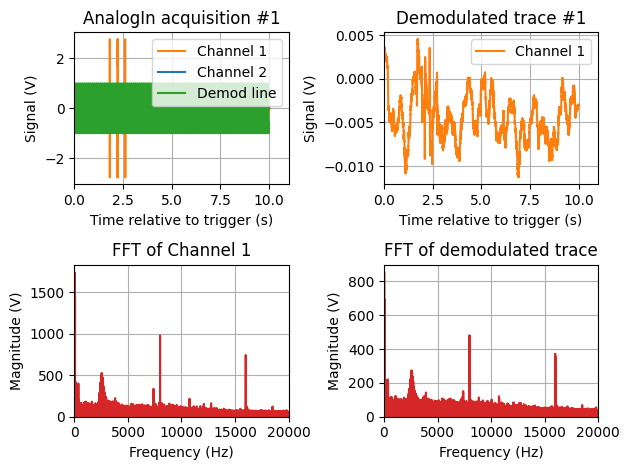

In [5]:

record = scan_heartbeat(ScanType.DEMOD,
    test_output=False,
    analog_out_frequency = 10.0,
    analog_out_amplitude = 2.0,
    analog_out_offset = 0.5,
    num_records= 1,
    analog_in_frequency = 40000,  # Example: 1 MHz sampling rate
    record_length_time = 10,
    record_length_samples=None)

record





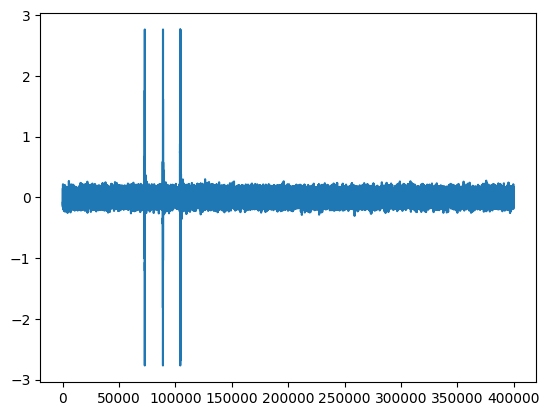

In [6]:
plt.plot(record[:, 0])
#plt.xlim([0,1000])

In [13]:
# Constants
SAMPLE_FREQ = 44100  # Sample frequency in Hz
WINDOW_SIZE = 44100  # Window size of the DFT in samples
WINDOW_STEP = 21050  # Step size of window
CONCERT_PITCH = 440  # Reference pitch (A4)
ALL_NOTES = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
windowSamples = [0 for _ in range(WINDOW_SIZE)]

In [31]:
def find_closest_note(pitch):
    i = int(np.round(np.log2(pitch / CONCERT_PITCH) * 12))
    closest_note = ALL_NOTES[i % 12] + str(4 + (i + 9) // 12)
    closest_pitch = CONCERT_PITCH * 2**(i / 12)
    return closest_note, closest_pitch


In [32]:
CONCERT_PITCH = 440
ALL_NOTES = ["A","A#","B","C","C#","D","D#","E","F","F#","G","G#"]
def find_closest_note(pitch):
  i = int(np.round(np.log2(pitch/CONCERT_PITCH)*12))
  closest_note = ALL_NOTES[i%12] + str(4 + (i + 9) // 12)
  closest_pitch = CONCERT_PITCH*2**(i/12)
  return closest_note, closest_pitch

In [33]:
import sounddevice as sd
import scipy.io.wavfile
import time

SAMPLE_FREQ = 44100 # Sampling frequency of the recording
SAMPLE_DUR = 2  # Duration of the recoding

print("Grab your guitar!")
time.sleep(1) # Gives you a second to grab your guitar ;)

myRecording = sd.rec(SAMPLE_DUR * SAMPLE_FREQ, samplerate=SAMPLE_FREQ, channels=1,dtype='float64')
print("Recording audio")
sd.wait()

sd.play(myRecording, SAMPLE_FREQ)
print("Playing audio")
sd.wait()

scipy.io.wavfile.write('example1.wav', SAMPLE_FREQ, myRecording)

Grab your guitar!
Recording audio
Playing audio


In [34]:
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np

print( record[0,:])

sampleFreq, myRecording = record[0,:], record[:,0]
sampleDur = len(myRecording)/sampleFreq
timeX = np.arange(0,sampleDur, 1/sampleFreq)

plt.plot(timeX, myRecording)
plt.ylabel('x(k)')
plt.xlabel('time[s]')
plt.show()

[ 0.14864584 -0.00063713]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

[0.29175374 0.28228645 0.17149005 ... 0.18042762 0.17149005 0.28228645]


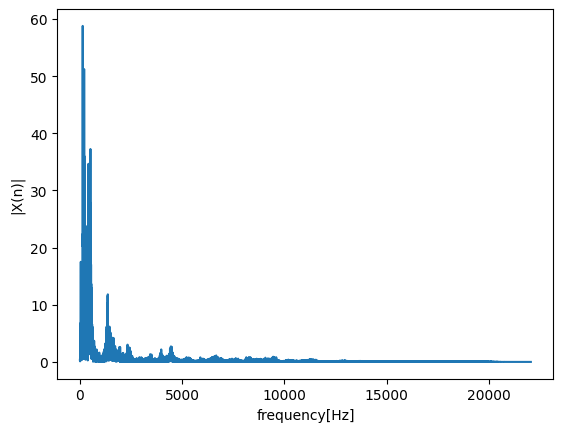

In [112]:
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft

sampleFreq, myRecording = scipy.io.wavfile.read("example1.wav")
sampleDur = len(myRecording)/sampleFreq
timeX = np.arange(0, sampleFreq/2, sampleFreq/len(myRecording))
absFreqSpectrum = abs(fft(myRecording))
print(absFreqSpectrum)

plt.plot(timeX, absFreqSpectrum[:len(myRecording)//2])
plt.ylabel('|X(n)|')
plt.xlabel('frequency[Hz]')
plt.show()
    

In [10]:
def _configure_analog_out_prime(analog_out, channel_index, frequency, amplitude, offset, shape, symmetry, node):
    # Set the output node frequency
    analog_out.nodeEnableSet(channel_index, node, True)  # Enable the node
    analog_out.nodeFunctionSet(channel_index, node, shape)  # Set waveform shape
    analog_out.nodeFrequencySet(channel_index, node, frequency)  # Set frequency
    analog_out.nodeAmplitudeSet(channel_index, node, amplitude)  # Set amplitude
    analog_out.nodeOffsetSet(channel_index, node, offset)  # Set offset
    analog_out.nodeSymmetrySet(channel_index, node, symmetry)  # Set symmetry


In [11]:
import sounddevice as sd
import numpy as np
import scipy.fftpack
import os

# General settings
SAMPLE_FREQ = 44100 # sample frequency in Hz
WINDOW_SIZE = 44100 # window size of the DFT in samples
WINDOW_STEP = 21050 # step size of window
WINDOW_T_LEN = WINDOW_SIZE / SAMPLE_FREQ # length of the window in seconds
SAMPLE_T_LENGTH = 1 / SAMPLE_FREQ # length between two samples in seconds
windowSamples = [0 for _ in range(WINDOW_SIZE)]

# This function finds the closest note for a given pitch
# Returns: note (e.g. A4, G#3, ..), pitch of the tone
CONCERT_PITCH = 440
ALL_NOTES = ["A","A#","B","C","C#","D","D#","E","F","F#","G","G#"]
def find_closest_note(pitch):
  i = int(np.round(np.log2(pitch/CONCERT_PITCH)*12))
  closest_note = ALL_NOTES[i%12] + str(4 + (i + 9) // 12)
  closest_pitch = CONCERT_PITCH*2**(i/12)
  return closest_note, closest_pitch

# The sounddecive callback function
# Provides us with new data once WINDOW_STEP samples have been fetched
def callback(indata, frames, time, status):
  global windowSamples
  if status:
    print(status)
  if True:
    windowSamples = np.concatenate((windowSamples,indata[:, 0])) # append new samples
    windowSamples = windowSamples[len(indata[:, 0]):] # remove old samples
    magnitudeSpec = abs( scipy.fftpack.fft(windowSamples)[:len(windowSamples)//2] )

    for i in range(int(62/(SAMPLE_FREQ/WINDOW_SIZE))):
      magnitudeSpec[i] = 0 #suppress mains hum

    maxInd = np.argmax(magnitudeSpec)
    maxFreq = maxInd * (SAMPLE_FREQ/WINDOW_SIZE)
    closestNote, closestPitch = find_closest_note(maxFreq)

    os.system('cls' if os.name=='nt' else 'clear')
    print(f"Closest note: {closestNote} {maxFreq:.1f}/{closestPitch:.1f}")
  else:
    print('no input')

print("Available audio devices:")
print(sd.query_devices())

# Start the microphone input stream
try:
  with sd.InputStream(channels=1, callback=callback,
    blocksize=WINDOW_STEP,
    samplerate=SAMPLE_FREQ):
    while True:
      pass
except KeyboardInterrupt:
    print("Exiting...")

Available audio devices:
  0 Gordo’s Phone Microphone, Core Audio (1 in, 0 out)
> 1 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 2 MacBook Air Speakers, Core Audio (0 in, 2 out)
Closest note: E6 1305.0/1318.5
Closest note: D#4 311.0/311.1
Closest note: D#4 311.0/311.1
Closest note: D#4 312.0/311.1
Closest note: D#4 311.0/311.1
Closest note: A3 221.0/220.0
Closest note: A3 220.0/220.0
Closest note: A3 220.0/220.0
Closest note: C6 1069.0/1046.5
Closest note: C#6 1101.0/1108.7
Closest note: C#6 1102.0/1108.7
Closest note: C6 1033.0/1046.5
Closest note: B3 249.0/246.9
Exiting...


Configuring analog output signal (10.0 Hz)...
HELLO LOOK AT ME 1
Started analog output.
Acquistion Mode: DwfAcquisitionMode.Record

scan_type: DEMOD
num_records: 1 record
analog_out_frequency: 10.0 Hz
analog_in_frequency: 4000 Hz
record_length_time: 10.0 seconds
record_length_samples: 40000 samples per record

Acquiring record 1...
Total number of ADC queries for this event: 33475
- NOTE - discarding newest 16383 of 56383 samples (29.1%); keeping 40000 samples.
- WARNING - 7 samples could be corrupted! Reduce sample frequency.
Estimated demodulation angle: -95.49867060062034 deg
n_filt 10000 THIS IS THE VALUE OF N_FILT
Finished acquisition.


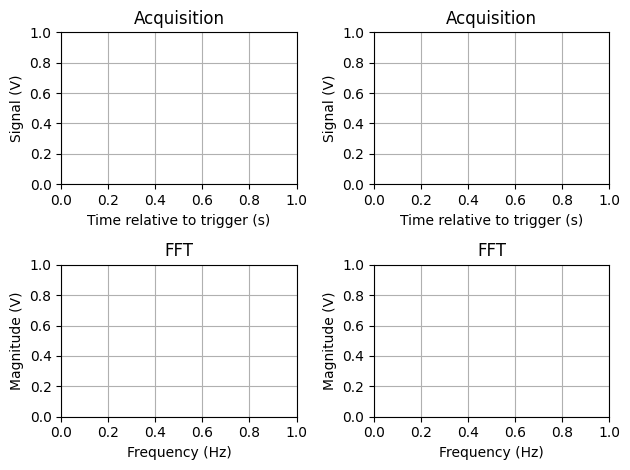

In [47]:

record = scan_heartbeat(ScanType.DEMOD,
    fig=None,
    axs=None,
    test_output=False,
    analog_out_frequency = 10.0,
    analog_out_amplitude = 2.0,
    analog_out_offset = 0.5,
    num_records= 1,
    analog_in_frequency = 4000,  # Example: 1 MHz sampling rate
    record_length_time = 10,
    record_length_samples=None)

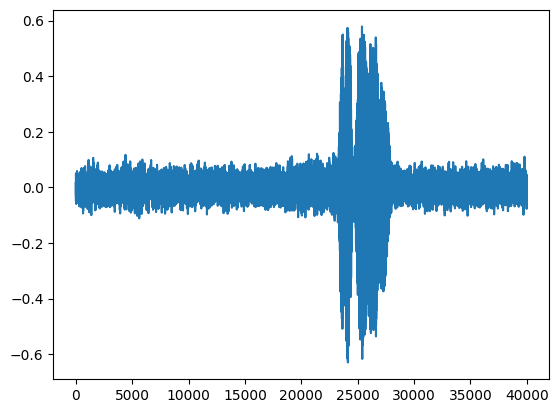

In [48]:
plt.plot(record[:,0])

In [9]:
CONCERT_PITCH = 440
ALL_NOTES = ["A","A#","B","C","C#","D","D#","E","F","F#","G","G#"]
def find_closest_note(pitch):
  i = int(np.round(np.log2(pitch/CONCERT_PITCH)*12))
  closest_note = ALL_NOTES[i%12] + str(4 + (i + 9) // 12)
  closest_pitch = CONCERT_PITCH*2**(i/12)
  return closest_note, closest_pitch

In [38]:
record.shape

(39999, 2)

In [2]:
from dwf_funcs import flat_or_sharp
import numpy as np
import scipy.fftpack
import time

# Assuming `find_closest_note` and `pitch` are defined elsewhere

"""CURRENTLY WORKING"""

# numer = 0

try:
    while True:

        # Take a measurement for onme second 
        record = scan_heartbeat(ScanType.DEMOD,
            test_output=False,
            analog_out_frequency = 10.0,
            analog_out_amplitude = 2.0,
            analog_out_offset = 0.5,
            num_records= 1,
            analog_in_frequency = 40000,  # Example: 1 MHz sampling rate
            record_length_time = 0.5,
            record_length_samples=None)
        
        time.sleep(1.0)  # Sleep for 1 second during each iteration

        # Ensure `windowSamples` and `record` are defined before using them
        windowSamples = np.concatenate((windowSamples, record[:, 0]))  # Append new samples
        windowSamples = windowSamples[len(record[:, 0]):]  # Remove old samples
        magnitudeSpec = abs(scipy.fftpack.fft(windowSamples)[:len(windowSamples) // 2])

        for i in range(int(62/(SAMPLE_FREQ/WINDOW_SIZE))):
            magnitudeSpec[i] = 0 #suppress mains hum

        maxInd = np.argmax(magnitudeSpec)
        maxFreq = maxInd * (SAMPLE_FREQ/WINDOW_SIZE) 
        closestNote, closestPitch = find_closest_note(maxFreq)

        # Debugging output
        print(len(magnitudeSpec))

        print(f"Closest note: {closestNote} {maxFreq:.1f}/{closestPitch:.1f}")

        if np.abs(maxFreq - closestPitch) <= 3:
            print("In tune!")
            flat_or_sharp(
                ScanType.DEMOD,
                test_output=False,
                analog_out_frequency=10.0,
                analog_out_amplitude=2.0,
                analog_out_offset=0.5,
                num_records=1,
                analog_in_frequency=40000,  # Example: 1 MHz sampling rate
                record_length_time=10,
                record_length_samples=None,
                analog_out_channel_index=ChannelIndex.CH1
            )
            
        else:
            print("Not in tune!")
            flat_or_sharp(
                ScanType.DEMOD,
                test_output=False,
                analog_out_frequency=10.0,
                analog_out_amplitude=2.0,
                analog_out_offset=0.5,
                num_records=1,
                analog_in_frequency=40000,  # Example: 1 MHz sampling rate
                record_length_time=10,
                record_length_samples=None,
                analog_out_channel_index=ChannelIndex.CH2
            )

except KeyboardInterrupt:
    print("Program quit successfully.")



NameError: name 'scan_heartbeat' is not defined

In [102]:
# Initialize the WaveForms library
dwf = pydwf.DwfLibrary()

# Open the first available device
device = dwf  # Use -1 to select the first available device


In [14]:
from pydwf import DwfLibrary
import numpy as np
import scipy.fftpack
import os
import time

# General settings
SAMPLE_FREQ = 44100  # sample frequency in Hz
WINDOW_SIZE = 44100  # window size of the DFT in samples
WINDOW_STEP = 21050  # step size of the window (not directly applicable here)
WINDOW_T_LEN = WINDOW_SIZE / SAMPLE_FREQ  # length of the window in seconds
SAMPLE_T_LENGTH = 1 / SAMPLE_FREQ  # length between two samples in seconds

# This function finds the closest note for a given pitch
CONCERT_PITCH = 440
ALL_NOTES = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]


def find_closest_note(pitch):
    i = int(np.round(np.log2(pitch / CONCERT_PITCH) * 12))
    closest_note = ALL_NOTES[i % 12] + str(4 + (i + 9) // 12)
    closest_pitch = CONCERT_PITCH * 2 ** (i / 12)
    return closest_note, closest_pitch


# Initialize the WaveForms library and device
dwf = DwfLibrary()

try:
    # Open the first available device
    with openDwfDevice(dwf) as device:

        # Configure the ADS for analog input (oscilloscope)
        device.analogIn.channelEnableSet(0, True)  # Enable CH1
        device.analogIn.channelRangeSet(0, 5.0)  # Set input range to ±5V
        device.analogIn.acquisitionModeSet(device.analogIn.AcquisitionMode.Record)
        device.analogIn.frequencySet(SAMPLE_FREQ)  # Sampling frequency
        device.analogIn.recordLengthSet(WINDOW_T_LEN)  # Record length in seconds

        # Start the acquisition
        device.analogIn.configure(False, True)

        print("Starting data acquisition...")
        while True:
            # Wait for acquisition to complete
            status = device.analogIn.status(True)
            if status == device.analogIn.Status.Done:
                break
            time.sleep(0.01)  # Avoid busy-waiting

        # Retrieve data from CH1
        windowSamples = device.analogIn.statusData(0, device.analogIn.recordLengthGet())

        # Perform FFT on the acquired data
        magnitudeSpec = abs(scipy.fftpack.fft(windowSamples)[: len(windowSamples) // 2])

        # Suppress mains hum frequencies (e.g., around 50-60 Hz)
        for i in range(int(62 / (SAMPLE_FREQ / WINDOW_SIZE))):
            magnitudeSpec[i] = 0

        # Find the dominant frequency
        maxInd = np.argmax(magnitudeSpec)
        maxFreq = maxInd * (SAMPLE_FREQ / WINDOW_SIZE)
        closestNote, closestPitch = find_closest_note(maxFreq)

        # Clear console and print results
        os.system("cls" if os.name == "nt" else "clear")
        print(f"Closest note: {closestNote} {maxFreq:.1f}/{closestPitch:.1f}")

except KeyboardInterrupt:
    print("Exiting...")


AttributeError: 'AnalogIn' object has no attribute 'AcquisitionMode'

In [ ]:
from pydwf import DwfLibrary, DwfEnumConfigInfo, DwfTriggerSource
import numpy as np
import scipy.fftpack
import os
import time

# General settings
SAMPLE_FREQ = 44100  # sample frequency in Hz
WINDOW_SIZE = 44100  # window size of the DFT in samples
WINDOW_T_LEN = WINDOW_SIZE / SAMPLE_FREQ  # length of the window in seconds
CONCERT_PITCH = 440
ALL_NOTES = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]


def find_closest_note(pitch):
    """Find the closest musical note to the given pitch."""
    i = int(np.round(np.log2(pitch / CONCERT_PITCH) * 12))
    closest_note = ALL_NOTES[i % 12] + str(4 + (i + 9) // 12)
    closest_pitch = CONCERT_PITCH * 2 ** (i / 12)
    return closest_note, closest_pitch


def _configure_analog_in(
    analog_in,
    frequency,
    record_length_time,
    channel_indices,
    channel_ranges,
    trigger_flag,
    trigger_source,
    trigger_level,
    trigger_channel,
):
    
    analog_in = device.analogIn

    """Configure the analog input settings for the ADS."""
    analog_in.frequencySet(frequency)
    analog_in.recordLengthSet(record_length_time)
    for idx, rng in zip(channel_indices, channel_ranges):
        analog_in.channelEnableSet(idx, True)
        analog_in.channelRangeSet(idx, rng)
    if trigger_flag:
        analog_in.triggerSourceSet(trigger_source)
        analog_in.triggerLevelSet(trigger_level)
        analog_in.triggerChannelSet(trigger_channel)


def _run_acquisition(
    analog_in,
    num_records,
    record_length_samples,
    sample_frequency,
):
    """Run the signal acquisition process and return the data."""
    data = []
    for _ in range(num_records):
        analog_in.configure(False, True)  # Start the acquisition
        while True:
            status = analog_in.status(True)
            if status == analog_in.Status.Done:
                break
            time.sleep(0.01)  # Avoid busy-waiting

        # Retrieve the data
        data_chunk = analog_in.statusData(0, record_length_samples)
        data.append(data_chunk)
    return np.concatenate(data)


def guitar_tuner():
    """Main function for the guitar tuner."""
    with openDwfDevice(
        DwfLibrary(),
        score_func=lambda conf_params: conf_params[DwfEnumConfigInfo.AnalogInBufferSize],
    ) as device:
        # Configure the analog input for the ADS
        print("Configuring analog input...")
        _configure_analog_in(
            analog_in=device.analogIn,
            frequency=SAMPLE_FREQ,
            record_length_time=WINDOW_T_LEN,
            channel_indices=(0,),  # Using CH1
            channel_ranges=(5.0,),  # Voltage range: ±5V
            trigger_flag=False,
            trigger_source=DwfTriggerSource.None,
            trigger_level=0.0,
            trigger_channel=0,
        )

        print("Starting data acquisition...")

        # Acquire data in real time
        while True:
            try:
                # Acquire one record
                data = _run_acquisition(
                    analog_in=device.analogIn,
                    num_records=1,
                    record_length_samples=WINDOW_SIZE,
                    sample_frequency=SAMPLE_FREQ,
                )

                # Perform FFT on the data
                magnitude_spec = np.abs(scipy.fftpack.fft(data)[: len(data) // 2])
                freqs = np.fft.fftfreq(len(data), d=1 / SAMPLE_FREQ)[: len(data) // 2]

                # Suppress mains hum (e.g., 50-60 Hz)
                for i in range(int(62 / (SAMPLE_FREQ / WINDOW_SIZE))):
                    magnitude_spec[i] = 0

                # Find the dominant frequency
                max_ind = np.argmax(magnitude_spec)
                max_freq = freqs[max_ind]

                # Find the closest note
                closest_note, closest_pitch = find_closest_note(max_freq)

                # Clear the console and print results
                os.system("cls" if os.name == "nt" else "clear")
                print(f"Closest note: {closest_note} {max_freq:.1f}/{closest_pitch:.1f} Hz")

            except KeyboardInterrupt:
                print("Guitar tuner stopped.")
                break


if __name__ == "__main__":
    guitar_tuner()


In [67]:
from pydwf import DwfLibrary, DwfEnumConfigInfo, DwfTriggerSource, AnalogIn
import numpy as np
import scipy.fftpack
import os
import time
from typing import Optional

# General settings
SAMPLE_FREQ = 44100  # Sample frequency in Hz
WINDOW_SIZE = 44100  # Window size for the DFT in samples
WINDOW_T_LEN = WINDOW_SIZE / SAMPLE_FREQ  # Record length in seconds
CONCERT_PITCH = 440
ALL_NOTES = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]

def find_closest_note(pitch: float) -> tuple[str, float]:
    """Find the closest musical note to the given pitch."""
    i = int(np.round(np.log2(pitch / CONCERT_PITCH) * 12))
    closest_note = ALL_NOTES[i % 12] + str(4 + (i + 9) // 12)
    closest_pitch = CONCERT_PITCH * 2 ** (i / 12)
    return closest_note, closest_pitch


def guitar_tuner(
    analog_in: AnalogIn,
    test_output: bool = False,
    num_records: int = 1,
    analog_in_frequency: Optional[float] = SAMPLE_FREQ,
    record_length_time: Optional[float] = WINDOW_T_LEN,
    record_length_samples: Optional[int] = WINDOW_SIZE,
    analog_in_channel_indices: tuple[int, ...] = (0,),  # Using Channel 1
    analog_in_channel_ranges: tuple[float, ...] = (5.0,),  # ±5V range
    analog_in_trigger_flag: bool = False,
    analog_in_trigger_source: DwfTriggerSource = DwfTriggerSource.AnalogOut1,
    analog_in_trigger_level: float = 0.0,
    analog_in_trigger_channel: int = 0,
) -> None:
    
    record_length_samples = int(SAMPLE_FREQ * record_length_time)

    """Main guitar tuner function."""
    with openDwfDevice(
        DwfLibrary(),
        score_func=lambda conf_params: conf_params[DwfEnumConfigInfo.AnalogInBufferSize],
    ) as device:

        # Configure analog input
        print("Configuring analog input...")
        device.analogIn.frequencySet(analog_in_frequency)
        device.analogIn.recordLengthSet(record_length_time)
        for idx, rng in zip(analog_in_channel_indices, analog_in_channel_ranges):
            device.analogIn.channelEnableSet(idx, True)
            device.analogIn.channelRangeSet(idx, rng)

        if analog_in_trigger_flag:
            device.analogIn.triggerSourceSet(analog_in_trigger_source)
            device.analogIn.triggerLevelSet(analog_in_trigger_level)
            device.analogIn.triggerChannelSet(analog_in_trigger_channel)

        print("Starting data acquisition...")

        if test_output:
            print("Outputting signal continuously. Interrupt to stop.")
            try:
                while True:
                    time.sleep(1.0)
            except KeyboardInterrupt:
                print("Program stopped.")
                return None
            
        record = []

        total_samples_lost = 0
        total_samples_corrupted = 0
        num_adc_queries = 0

        try:
            while True:
                # Start the acquisition
                device.analogIn.configure(False, True)

                print("step 1 success")

                # Wait for acquisition to complete (sleep is required in this method)
                time.sleep(record_length_time)

                print("step 2 success")

                current_samples_available, current_samples_lost, current_samples_corrupted = analog_in.statusRecord()

                total_samples_lost += current_samples_lost
                total_samples_corrupted += current_samples_corrupted

                if current_samples_lost != 0:
                    # Append NaN samples as placeholders for lost samples
                    lost_samples = np.full((current_samples_lost, len(channel_indices)), np.nan)
                    record.append(lost_samples)

                if current_samples_available != 0:
                     # Append samples read from both channels
                    data = np.vstack(
                    [
                        analog_in.statusData(channel_index, current_samples_available)
                        for channel_index in channel_indices
                    ])
                record.append(current_samples)


                # # Retrieve data from the analog input channel
                # data = np.array(
                #     device.analogIn.statusData(
                #          ChannelIndex.CH1, record_length_samples
                #     )
                # )

                print("step 3 success")


                # Perform FFT on the data
                magnitude_spec = np.abs(scipy.fftpack.fft(data)[: len(data) // 2])
                freqs = np.fft.fftfreq(len(data), d=1 / SAMPLE_FREQ)[: len(data) // 2]

                # Suppress mains hum (e.g., 50-60 Hz)
                for i in range(int(62 / (SAMPLE_FREQ / WINDOW_SIZE))):
                    magnitude_spec[i] = 0

                # Find the dominant frequency
                max_index = np.argmax(magnitude_spec)
                max_freq = freqs[max_index]

                # Find the closest musical note
                closest_note, closest_pitch = find_closest_note(max_freq)

                # Display the result
                os.system("cls" if os.name == "nt" else "clear")
                print(f"Closest note: {closest_note} {max_freq:.1f} Hz (Expected: {closest_pitch:.1f} Hz)")

        except KeyboardInterrupt:
            print("Tuner stopped.")

guitar_tuner(
    AnalogIn,
    test_output = False,
    num_records = 1,
    analog_in_frequency = SAMPLE_FREQ,
    record_length_time = WINDOW_T_LEN,
    record_length_samples = WINDOW_SIZE,
    analog_in_channel_indices = (0,),  # Using CH1
    analog_in_channel_ranges = (5.0,),  # ±5V range
    analog_in_trigger_flag = False,
    analog_in_trigger_source = DwfTriggerSource.AnalogOut1,
    analog_in_trigger_level = 0.0,
    analog_in_trigger_channel = 0)

Configuring analog input...
Starting data acquisition...
step 1 success
step 2 success


TypeError: AnalogIn.statusRecord() missing 1 required positional argument: 'self'

In [44]:
device.analogIn.statusData?

Signature: device.analogIn.statusData(channel_index: int, count: int) -> numpy.ndarray
Docstring:
Retrieve the acquired data samples from the specified |AnalogIn| instrument channel.

This method returns samples as voltages, calculated from the raw, binary sample values as follows:

.. code-block:: python

    voltages = analogIn.channelOffsetGet(channel_index) + \
               analogIn.channelRangeGet(channel_index) * (raw_samples / 65536.0)

Note that the applied calibration is channel-dependent.

Parameters:
    channel_index (int): The channel index, in the range 0 to :py:meth:`channelCount`-1.
    count (int): The number of samples to retrieve.

Returns:
    nd.array: A 1D numpy array of floats, in Volts.

Raises:
    DwfLibraryError: An error occurred while retrieving the sample data.
File:      ~/miniforge3/lib/python3.11/site-packages/pydwf/core/api/analog_in.py
Type:      method

In [71]:
import threading
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def scan_heartbeat_live(
    scan_type: ScanType,
    fig: Optional[Figure],
    axs: Optional[NDArray],
    stop_event: threading.Event,
    **kwargs,
) -> Optional[tuple[Figure, NDArray]]:
    """
    Perform a heartbeat scan and dynamically update plots while data collection is in progress.

    Parameters
    ----------
    scan_type: ScanType
        Type of scan to perform.
    fig: Figure
        Matplotlib figure to use for plotting.
    axs: NDArray
        Array of axes for plotting.
    stop_event: threading.Event
        Event to signal when to stop data collection.
    kwargs: dict
        Additional arguments passed to the original `scan_heartbeat` function.
    """
    def data_acquisition_loop():
        """Continuously acquire data and update the plots."""
        nonlocal fig, axs

        with openDwfDevice(
            DwfLibrary(),
            score_func=lambda conf_params: conf_params[DwfEnumConfigInfo.AnalogInBufferSize]
        ) as device:
            print(f'Configuring analog output signal ({kwargs.get("analog_out_frequency", 10.0)} Hz)...')
            _configure_analog_out(
                analog_out=device.analogOut,
                channel_index=kwargs.get("analog_out_channel_index", ChannelIndex.CH1),
                frequency=kwargs.get("analog_out_frequency", 10.0),
                amplitude=kwargs.get("analog_out_amplitude", 1.0),
                offset=kwargs.get("analog_out_offset", 0.0),
                shape=kwargs.get("analog_out_shape", DwfAnalogOutFunction.Sine),
                symmetry=kwargs.get("analog_out_symmetry", 50.0),
                node=kwargs.get("analog_out_node", pydwf.DwfAnalogOutNode.Carrier)
            )

            print('Started analog output.')
            time.sleep(1.0)  # Ensure signal stability

            _configure_analog_in(
                analog_in=device.analogIn,
                frequency=kwargs.get("analog_in_frequency", None),
                record_length_time=kwargs.get("record_length_time", 10.0),
                channel_indices=kwargs.get("analog_in_channel_indices", (ChannelIndex.CH1, ChannelIndex.CH2)),
                channel_ranges=kwargs.get("analog_in_channel_ranges", (5.0, 5.0)),
                trigger_flag=kwargs.get("analog_in_trigger_flag", True),
                trigger_source=kwargs.get("analog_in_trigger_source", DwfTriggerSource.AnalogOut1),
                trigger_level=kwargs.get("analog_in_trigger_level", 0.0),
                trigger_channel=kwargs.get("analog_in_trigger_channel", ChannelIndex.CH1)
            )

            while not stop_event.is_set():
                _run_acquistion(
                    analog_in=device.analogIn,
                    scan_type=scan_type,
                    fig=fig,
                    axs=axs,
                    num_records=kwargs.get("num_records", 1),
                    analog_out_frequency=kwargs.get("analog_out_frequency", 10.0),
                    analog_in_frequency=kwargs.get("analog_in_frequency", None),
                    record_length_time=kwargs.get("record_length_time", 10.0),
                    record_length_samples=kwargs.get("record_length_samples", 16384),
                    channel_indices=kwargs.get("analog_in_channel_indices", (ChannelIndex.CH1, ChannelIndex.CH2)),
                    analog_in_trigger_flag=kwargs.get("analog_in_trigger_flag", True),
                    overplot_fft=kwargs.get("overplot_fft", True),
                    xlim_time_raw=kwargs.get("xlim_time_raw", None),
                    xlim_freq_raw=kwargs.get("xlim_freq_raw", None),
                    xlim_time_result=kwargs.get("xlim_time_result", None),
                    xlim_freq_result=kwargs.get("xlim_freq_result", None),
                    cycler_time_raw=kwargs.get("cycler_time_raw", None),
                    cycler_freq_raw=kwargs.get("cycler_freq_raw", None),
                    cycler_time_result=kwargs.get("cycler_time_result", None),
                    cycler_freq_result=kwargs.get("cycler_freq_result", None)
                )

    acquisition_thread = threading.Thread(target=data_acquisition_loop)
    acquisition_thread.start()

    return fig, axs


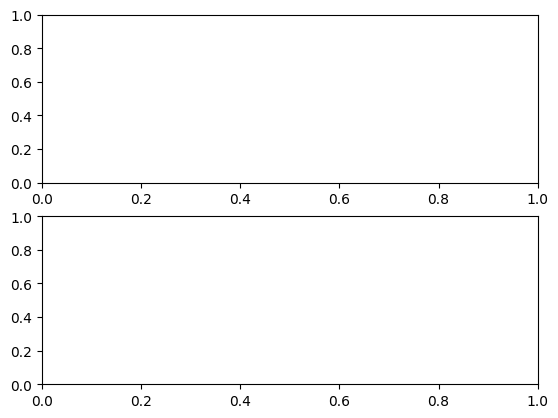

Configuring analog output signal (20.0 Hz)...
Started analog output.


Exception in thread Thread-73 (data_acquisition_loop):
Traceback (most recent call last):
  File "/Users/jakelansberg/miniforge3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/jakelansberg/miniforge3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/jakelansberg/miniforge3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/l6/rzfyz2xj2gbbfl9kz61x4s480000gn/T/ipykernel_72879/2179265999.py", line 52, in data_acquisition_loop
  File "/Users/jakelansberg/Desktop/111a/111a_FP/physics-111a-student/Final Project/dwf_funcs.py", line 462, in _configure_analog_in
    analog_in.frequencySet(frequency)
  File "/Users/jakelansberg/miniforge3/lib/python3.11/site-packages/pydwf/core/api/analog_in.py", line 535, in frequencySet
    result = self.lib.FDwfAnalogInFrequencySet(self.hdwf, sample_frequency)
             ^^^^^^^

Stopping acquisition...


In [76]:
import threading
import matplotlib.pyplot as plt

# Create a stop event to control the loop
stop_event = threading.Event()

# Create figure and axes
fig, axs = plt.subplots(2, 1)

# Start live plotting
scan_type = ScanType.LOCKIN  # Example scan type
fig, axs = scan_heartbeat_live(
    scan_type=scan_type,
    fig=fig,
    axs=axs,
    stop_event=stop_event,
    num_records=10,
    analog_out_frequency=20.0,
    record_length_time=5.0
)

# Let the acquisition run for 30 seconds
try:
    plt.show(block=False)  # Show the live plot
    time.sleep(30.0)  # Adjust the sleep time for your needs
finally:
    stop_event.set()  # Signal the loop to stop
    print("Stopping acquisition...")


In [ ]:
def flat_or_sharp(
    scan_type: ScanType,
    test_output: bool = False,
    num_records: int = 1,
    analog_out_frequency: float = 10.0,
    analog_out_amplitude: float = 1.0,
    analog_out_offset: float = 0.0,
    analog_out_shape: DwfAnalogOutFunction = DwfAnalogOutFunction.Sine,
    analog_in_channel_indices: tuple[ChannelIndex, ...] = (ChannelIndex.CH1, ChannelIndex.CH2),
    analog_in_channel_ranges: tuple[float, ...] = (5.0, 5.0),
    analog_in_frequency: Optional[float] = None,
    record_length_time: Optional[float] = 10.0,
    record_length_samples: Optional[int] = 16384,
    analog_out_channel_index: ChannelIndex = ChannelIndex.CH1,
    analog_out_symmetry: float = 50.0,
    analog_out_node: DwfAnalogOutNode = DwfAnalogOutNode.Carrier,
    analog_in_trigger_flag: bool = True,
    analog_in_trigger_source: DwfTriggerSource = DwfTriggerSource.AnalogOut1,
    analog_in_trigger_level: float = 0.0,
    analog_in_trigger_channel: ChannelIndex = ChannelIndex.CH1,
    overplot_fft: bool = True,
    xlim_time_raw: RangeLimits = None,
    xlim_freq_raw: RangeLimits = None,
    xlim_time_result: RangeLimits = None,
    xlim_freq_result: RangeLimits = None,
    cycler_time_raw: Optional[Cycler] = None,
    cycler_freq_raw: Optional[Cycler] = None,
    cycler_time_result: Optional[Cycler] = None,
    cycler_freq_result: Optional[Cycler] = None
    ) -> Optional[tuple[Figure, NDArray]]:
    '''
    Perform a heartbeat scan and produce plots.

    If either `fig` or `axs` is ``None``, a new ``Figure`` will be created
    automatically, but plots made in notebooks may not update dynamically.

    Exactly two of `analog_in_frequency`, `record_length_time`, and
    `record_length_samples` must be specified (not ``None``).

    Parameters
    ----------
    scan_type: str
        One of ``ScanType.TEST``, ``ScanType.DEMOD``, ``ScanType.LOCKIN``.
    fig: Figure or None
        Figure created by ``create_figure()`` that will contain all plots.
    axs: NDArray of Axes or None
        Axes array created by ``create_figure()``, one ``Axes`` object for each
        plot in the figure.
    test_output: bool
        If ``True``, do not scan for heartbeat; only output a signal with the
        given parameters until user keyboard interrupt.
    num_records: int
        The number of full records to take.
    analog_out_frequency, analog_out_amplitude, analog_out_offset: float
        The frequency (Hz), amplitude (V), and offset (V) of the Wavegen.
    analog_out_shape: DwfAnalogOutFunction
        The wave shape, e.g. ``DwfAnalogOutFunction.Sine``,
        ``DwfAnalogOutFunction.DC``, ``DwfAnalogOutFunction.Triangle``,
        ``DwfAnalogOutFunction.Square``. See pydwf documentation for full list.
    analog_in_channel_indices, analog_in_channel_ranges: tuple
        A tuple of the scope channel indices and a tuple of the corresponding
        scope channel measurement ranges in volts. See the appendix in the lab
        for more information on channel ranges. Channel 1 is
        ``ChannelIndices.CH1`` and Channel 2 is ``ChannelIndices.CH2``.
        For example, to use only Channel 1 and to set the range to 5 V, set
        ``channel_indices=(ChannelIndices.CH1,)`` and ``channel_ranges=(5,)``.
        The first channel in the tuple is expected to be the one used to
        measure the output signal, and the second channel in the tuple is
        expected to be the one used to measure the Wavegen.
    analog_in_frequency: float or None
        The sampling frequency (Hz).
    record_length_time: float or None
        The time (s) for one record.
    record_length_samples: int or None
        The number of samples to take for one record.

    Returns
    -------
    tuple[Figure, NDArray[Axes]] or None
        A ``Figure`` and array of ``Axes``, or ``None`` if `test_output` is ``True``.

    Other AnalogOut Parameters
    --------------------------
    analog_out_channel_index: ChannelIndex
         The index corresponding to the desired output channel.
    analog_out_symmetry: float
        Symmetry parameter between 0 and 100 that modifies the wave shape.
    analog_out_node: DwfAnalogOutNode
        Node corresponding to a parameter column of the modulation tab in the
        Wavegen GUI.

    Other AnalogIn Parameters
    -------------------------
    analog_in_trigger_flag: bool
        Specifies whether or not to use a trigger.
    analog_in_trigger_source: DwfTriggerSource
        Instrument to trigger on.
    analog_in_trigger_level: float
        Trigger level (V).
    analog_in_trigger_channel: ChannelIndex
        Index corresponding to desired channel to trigger on.

    Other Plotting Parameters
    -------------------------
    overplot_fft: bool
        If ``True``, plot every new FFT line on top of the previous lines.
        If ``False``, remove previous line before plotting a new one.
    xlim_time_raw, xlim_freq_raw, xlim_time_result, xlim_freq_result: tuple[float, float] or None
        The x-limits for the raw/result time/FFT plots. If ``None``, will be
        chosen automatically.
    cycler_time_raw, cycler_freq_raw, cycler_time_result, cycler_freq_result: Cycler or None
        Property cycle ``Cycler`` objects for the various axes. Change the
        defaults to set, for example, line color cycles. If `cycler_time_raw` is
        ``None``, it will be set according to `analog_in_channel_indices`.
        The same is true for `cycler_time_result`. Use these instead of
        ``Axes.set_prop_cycle()`` or ``plt.rcParams['axes.prop_cycle']``;
        properties are reset before every acquisition.
    '''

    # if not test_output:

    #     if fig is None or axs is None:
    #         fig, axs = create_figure(scan_type=scan_type)
    #     else:
    #         _check_axs(scan_type, axs)

    #     analog_in_frequency, record_length_time, record_length_samples = _calc_scope_params(
    #         analog_in_frequency, record_length_time, record_length_samples
    #     )

    #     if scan_type in (ScanType.DEMOD, ScanType.LOCKIN) and len(analog_in_channel_indices) != 2:
    #         raise ValueError(f'scan_type {scan_type} expects analog_in_channel_indices of length 2')

    #     cycler_time_raw, cycler_time_result, cycler_freq_raw, cycler_freq_result = _set_color_cycles(
    #         analog_in_channel_indices,
    #         cycler_time_raw,
    #         cycler_time_result,
    #         cycler_freq_raw,
    #         cycler_freq_result
    #     )

    with openDwfDevice(
        DwfLibrary(),
        score_func=lambda conf_params: conf_params[DwfEnumConfigInfo.AnalogInBufferSize]
    ) as device:

        print(f'Configuring analog output signal ({analog_out_frequency} Hz)...')

        _configure_analog_out(
            analog_out=device.analogOut,
            channel_index=analog_out_channel_index,
            frequency=analog_out_frequency,
            amplitude=analog_out_amplitude,
            offset=analog_out_offset,
            shape=analog_out_shape,
            symmetry=analog_out_symmetry,
            node=analog_out_node
        )

        print('Started analog output.')

        if test_output:
            print('Output running continuously. Interrupt program to quit.')
            try:
                while True:
                    time.sleep(1.0)
            except KeyboardInterrupt:
                print('Program quit successfully.')
                return None

        # Wait for a bit to ensure the stability of the analog output signals
        time.sleep(1.0)

        _configure_analog_in(
            analog_in=device.analogIn,
            frequency=analog_in_frequency,
            record_length_time=record_length_time,
            channel_indices=analog_in_channel_indices,
            channel_ranges=analog_in_channel_ranges,
            trigger_flag=analog_in_trigger_flag,
            trigger_source=analog_in_trigger_source,
            trigger_level=analog_in_trigger_level,
            trigger_channel=analog_in_trigger_channel
        )

        return None